# 0. Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Loading Data 

In [2]:
data_path = '../datasets/'
files = listdir(data_path)

In [3]:
files

['campeonato-brasileiro-cartoes.csv',
 'campeonato-brasileiro-full.csv',
 'campeonato-brasileiro-estatisticas-full.csv',
 'campeonato-brasileiro-gols.csv',
 'Legenda.txt']

In [4]:
cards = files[0]
full = files[1]
stats = files[2]
goals = files[3]

## 1.1 Cards

In [5]:
df_cards = pd.read_csv(data_path + cards)
df_cards.head()

,partida_id,rodada,clube,cartao,atleta,num_camisa,posicao,minuto
0,4607,1,Figueirense,Amarelo,Thiago Heleno,4.0,Zagueiro,44
1,4607,1,Figueirense,Amarelo,Paulo Roberto da Silva,28.0,NaN,66
2,4608,1,Internacional,Amarelo,Juan Silveira dos Santos,4.0,Zagueiro,20
3,4608,1,Vitoria,Amarelo,Vinícius Santos Silva,NaN,NaN,82
4,4608,1,Internacional,Amarelo,Andrés D'Alessandro,10.0,Meio-campo,72


In [6]:
df_cards.isna().sum() / df_cards.shape[0]

partida_id    0.000000
rodada        0.000000
clube         0.000000
cartao        0.000000
atleta        0.000406
num_camisa    0.026138
posicao       0.081121
minuto        0.000000
dtype: float64

In [7]:
df_cards.shape

(14768, 8)

In [8]:
df_cards.dtypes

partida_id      int64
rodada          int64
clube          object
cartao         object
atleta         object
num_camisa    float64
posicao        object
minuto         object
dtype: object

Quantidade de NaN é no máximo 8% em relação ao total da registros.

## 1.2 Full

In [9]:
df_full = pd.read_csv(data_path + full)
df_full

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7640,7641,38,2021-12-12,21:33,Domingo,Bragantino,Internacional,4-2-3-1,3-4-2-1,D. Aguirre Camblor,D. Aguirre Camblor,Bragantino,nabizao,1,0,SP,RS,SP
7641,7642,38,2021-12-12,21:30,Domingo,Sport,Athletico-PR,4-2-3-1,3-4-2-1,J. Freitas,J. Freitas,-,arena de pernambuco,1,1,PE,PR,-
7642,7643,38,2021-12-12,21:33,Domingo,Juventude,Corinthians,3-4-3,4-3-3,S. Campos Junior,S. Campos Junior,Juventude,alfredo jaconi,1,0,RS,SP,RS
7643,7644,38,2021-12-12,21:33,Domingo,Gremio,Atletico-MG,4-2-3-1,4-2-3-1,A. Stival,A. Stival,Gremio,arena do gremio,4,3,RS,MG,RS


In [10]:
df_full_fla_man = df_full[df_full['mandante'] == 'Flamengo']
df_full_fla_vis = df_full[df_full['visitante'] == 'Flamengo']

In [11]:
df_full_fla = df_full_fla_man.append(df_full_fla_vis)
df_full_fla

/tmp/ipykernel_39509/1212725605.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_full_fla = df_full_fla_man.append(df_full_fla_vis)


,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
35,48,3,2003-04-13,18:00,Domingo,Flamengo,Fluminense,NaN,NaN,NaN,NaN,Flamengo,maracana,4,1,RJ,RJ,RJ
50,51,5,2003-04-19,18:00,Sabado,Flamengo,Santos,NaN,NaN,NaN,NaN,Santos,maracana,0,2,RJ,SP,SP
72,73,7,2003-05-03,16:00,Sabado,Flamengo,Vitoria,NaN,NaN,NaN,NaN,Flamengo,maracana,2,1,RJ,BA,RJ
106,107,9,2003-05-18,18:00,Domingo,Flamengo,Guarani,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,SP,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7563,7584,30,2021-11-08,11:06,Segunda-feira,Chapecoense,Flamengo,4-2-3-1,4-4-2,Renato Gaúcho,Renato Gaúcho,-,arena conda,2,2,SC,RJ,-
7580,7591,32,2021-11-14,16:01,Domingo,Sao Paulo,Flamengo,4-3-1-2,4-4-2,Renato Gaúcho,Renato Gaúcho,Flamengo,morumbi,0,4,SP,RJ,RJ
7600,7551,34,2021-11-11,21:30,Quinta-feira,Internacional,Flamengo,4-2-3-1,4-2-3-1,Renato Gaúcho,Renato Gaúcho,Flamengo,estadio jose pinheiro borda,1,2,RS,RJ,RJ
7614,7615,35,2021-12-12,20:00,Domingo,Sport,Flamengo,4-2-3-1,4-2-2-2,M. Souza,M. Souza,-,arena de pernambuco,1,1,PE,RJ,-


In [12]:
df_full = df_full_fla.copy()

In [13]:
print('% of NaN')
df_full.isna().sum()/df_full.shape[0]

% of NaN


ID                    0.000000
rodada                0.000000
data                  0.000000
hora                  0.000000
dia                   0.000000
mandante              0.000000
visitante             0.000000
formacao_mandante     0.638814
formacao_visitante    0.638814
tecnico_mandante      0.590296
tecnico_visitante     0.590296
vencedor              0.000000
arena                 0.000000
mandante_placar       0.000000
visitante_placar      0.000000
mandante_estado       0.000000
visitante_estado      0.000000
estado_vencedor       0.000000
dtype: float64

In [14]:
df_full.dtypes

ID                     int64
rodada                 int64
data                  object
hora                  object
dia                   object
mandante              object
visitante             object
formacao_mandante     object
formacao_visitante    object
tecnico_mandante      object
tecnico_visitante     object
vencedor              object
arena                 object
mandante_placar        int64
visitante_placar       int64
mandante_estado       object
visitante_estado      object
estado_vencedor       object
dtype: object

In [15]:
df_full['data'] = pd.to_datetime(df_full.data, yearfirst=True)

In [16]:
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
35,48,3,2003-04-13,18:00,Domingo,Flamengo,Fluminense,NaN,NaN,NaN,NaN,Flamengo,maracana,4,1,RJ,RJ,RJ
50,51,5,2003-04-19,18:00,Sabado,Flamengo,Santos,NaN,NaN,NaN,NaN,Santos,maracana,0,2,RJ,SP,SP
72,73,7,2003-05-03,16:00,Sabado,Flamengo,Vitoria,NaN,NaN,NaN,NaN,Flamengo,maracana,2,1,RJ,BA,RJ
106,107,9,2003-05-18,18:00,Domingo,Flamengo,Guarani,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,SP,-


In [17]:
df_full.dtypes

ID                             int64
rodada                         int64
data                  datetime64[ns]
hora                          object
dia                           object
mandante                      object
visitante                     object
formacao_mandante             object
formacao_visitante            object
tecnico_mandante              object
tecnico_visitante             object
vencedor                      object
arena                         object
mandante_placar                int64
visitante_placar               int64
mandante_estado               object
visitante_estado              object
estado_vencedor               object
dtype: object

## 1.3 Stats 

In [18]:
df_stats = pd.read_csv(data_path + stats)
df_stats.head()

,partida_id,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


In [19]:
df_stats.shape

(15290, 13)

In [20]:
print('% of NaN')
df_stats.isna().sum()/df_stats.shape[0]

% of NaN


partida_id         0.000000
rodada             0.000000
clube              0.000000
chutes             0.000000
chutes_no_alvo     0.000000
posse_de_bola      0.602485
passes             0.000000
precisao_passes    0.602485
faltas             0.000000
cartao_amarelo     0.000000
cartao_vermelho    0.000000
impedimentos       0.000000
escanteios         0.000000
dtype: float64

In [21]:
df_stats.dtypes

partida_id          int64
rodada              int64
clube              object
chutes              int64
chutes_no_alvo      int64
posse_de_bola      object
passes              int64
precisao_passes    object
faltas              int64
cartao_amarelo      int64
cartao_vermelho     int64
impedimentos        int64
escanteios          int64
dtype: object

<AxesSubplot:>

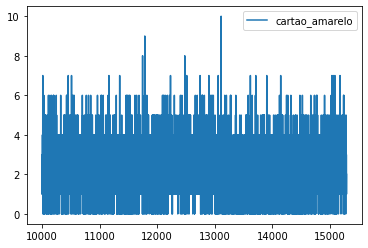

In [22]:
df_stats[10000:].plot(y='cartao_amarelo')

## 1.4 Goals 

In [23]:
df_goals = pd.read_csv(data_path + goals)
df_goals.head()

,partida_id,rodada,clube,atleta,minuto
0,4607,1,Fluminense,Rafael Sóbis,31
1,4607,1,Fluminense,Fred,45
2,4607,1,Fluminense,Nirley da Silva Fonseca,59
3,4608,1,Internacional,Charles Aránguiz,6
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16


In [24]:
df_goals['gol'] = 1

In [25]:
df_goals.head()

,partida_id,rodada,clube,atleta,minuto,gol
0,4607,1,Fluminense,Rafael Sóbis,31,1
1,4607,1,Fluminense,Fred,45,1
2,4607,1,Fluminense,Nirley da Silva Fonseca,59,1
3,4608,1,Internacional,Charles Aránguiz,6,1
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16,1


In [26]:
df_goals.shape

(7081, 6)

In [27]:
print('% of NaN')
df_goals.isna().sum()/df_goals.shape[0]

% of NaN


partida_id    0.0
rodada        0.0
clube         0.0
atleta        0.0
minuto        0.0
gol           0.0
dtype: float64

## 1.5 Legend

**Legenda - campeonato-brasileiro-full.csv**
- ID : ID da partida
- Rodada : Rodada que aconteceu a partida
- Data : Data que ocorreu a partida
- Horário :  Horário que ocorreu a partida
- Dia : Dia da semana que ocorreu a partida
- Mandante : Clube mandante                      
- Visitante : Clube Visitante
- formacao_mandante: Formação do mandante
- formacao_visitante: Formação do visitante
- tecnico_mandante: Técnico do mandante
- tecnico_visitante: Técnico do visitante
- Vencedor : Clube vencedor da partida. Quando tiver "-", é um empate
- Arena : Arena que ocorreu a partida                      
- Mandante Placar : Gols que o clube mandante fez na partida                      
- Visitante Placar : Gols que o clube visitante fez na partida                      
- Estado Mandante : Estado do clube mandatorio                      
- Estado Visitante : Estado do clube visitante                      
- Estado Vencedor : Estado do clube vencedor. Quando tiver "-", é um empate


**Legenda - campeonato-brasileiro-estatisticas-full.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Chutes - Finalizações
- Chutes a gol - Finalizações na direção do gol
- Posse de bola - Percentual da posse de bola
- Passes - Quantidade de passes que o clube deu na partida
- precisao_passes - Percentual da precisão de passe
- Faltas - Quantidade de faltas cometidas na partida
- cartao_amarelo - Quantidade de cartões amarelos para o clube na partida
- cartao_vermelho - Quantidade de cartões vermelhos para o clube na partida
- Impedimentos - Quantidade de impedimentos para o clube na partida
- Escanteios - Quantidade de escanteios para o clube na partida


**Legenda - campeonato-brasileiro-gols.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Atleta - Nome do atleta que fez o gol
- Minuto - Minuto na partida em que o gol foi marcado


**Legenda - campeonato-brasileiro-cartoes.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Cartao - Cor do cartão aplicado
- Atleta - Nome do atleta punido pelo cartão
- num_camisa - Número da camisa do atleta
- Posicao - Posição na partida em que o atleta se encontra
- Minuto - Minuto na partida em que o cartão foi aplicado

## 1.6 Filling NA and and filtering data

### 1.6.1 Selecting recent games (5 years) 

In [28]:
df_full_recent = df_full[df_full['data'] > '2018-01-01']

In [29]:
# dataframe das partidas de 2018 em diante
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
6136,6137,2,2018-04-21,19:00,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,E. Alves Moreira,E. Alves Moreira,Flamengo,maracana,2,0,RJ,MG,RJ
6158,6159,4,2018-05-06,16:00,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,O. Hellmann,O. Hellmann,Flamengo,maracana,2,0,RJ,RS,RJ
6176,6177,6,2018-05-19,19:01,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,J. Mannarino,J. Mannarino,-,maracana,1,1,RJ,RJ,-
6202,6203,8,2018-05-31,16:00,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,A. Ferreira,A. Ferreira,Flamengo,maracana,2,0,RJ,BA,RJ
6209,6210,9,2018-06-03,16:00,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,O. Loss,O. Loss,Flamengo,maracana,1,0,RJ,SP,RJ


In [30]:
columns = df_full_recent.columns.to_list()

### 1.6.2 Choosing some initial features to test 

In [31]:
columns = ['ID',
           'rodada',
           'data',
           'hora',
           'dia',
           'mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'vencedor',
           'arena',
           'mandante_estado',
           'visitante_estado']

df_full_recent = df_full_recent[columns]

In [32]:
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,vencedor,arena,mandante_estado,visitante_estado
6136,6137,2,2018-04-21,19:00,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,Flamengo,maracana,RJ,MG
6158,6159,4,2018-05-06,16:00,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,Flamengo,maracana,RJ,RS
6176,6177,6,2018-05-19,19:01,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,-,maracana,RJ,RJ
6202,6203,8,2018-05-31,16:00,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,Flamengo,maracana,RJ,BA
6209,6210,9,2018-06-03,16:00,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,Flamengo,maracana,RJ,SP


### 1.6.3 Selecting just recent stats (5 years) 

In [33]:
df_stats_recent = df_stats[df_stats['partida_id'] > 6137]

In [34]:
aux_val = []
for value in df_stats_recent['posse_de_bola'].values:
    if value != 'None':
        aux_val.append(np.float32(value[0:2]))
    else:
        aux_val.append(np.nan)

In [35]:
df_stats_recent.loc[:,'posse_de_bola'] = aux_val

/tmp/ipykernel_39509/1222983903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_recent.loc[:,'posse_de_bola'] = aux_val


In [36]:
aux_val = []
for value in df_stats_recent['precisao_passes'].values:
    if value != 'None':
        aux_val.append(np.float32(value[0:2]))
    else:
        aux_val.append(np.nan)

In [37]:
df_stats_recent.loc[:, 'precisao_passes'] = aux_val

/tmp/ipykernel_39509/2135160869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_recent.loc[:, 'precisao_passes'] = aux_val


In [38]:
df_stats_clube = df_stats_recent.groupby('clube').mean()
df_stats_clube = df_stats_clube.drop(['partida_id', 'rodada'], axis = 1)
df_stats_clube.head()

,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
clube,,,,,,,,,,
America-MG,12.891892,3.824324,47.364865,403.270270,78.094595,14.959459,1.945946,0.121622,1.675676,4.702703
Athletico-PR,11.284768,3.701987,53.061069,398.695364,82.732824,13.807947,1.913907,0.079470,1.245033,4.437086
Atletico-GO,11.421053,3.500000,48.039474,391.815789,79.000000,14.828947,2.223684,0.092105,1.342105,5.644737
Atletico-MG,14.814570,4.900662,56.068027,485.105960,83.197279,14.456954,1.880795,0.086093,1.476821,6.178808
Avai,11.657895,2.894737,46.555556,371.447368,77.388889,14.473684,1.947368,0.263158,1.157895,4.631579


In [39]:
for column in df_stats_clube.columns.tolist():
    # df_full_recent['mandante_' + column] = df_full_recent['mandante'].map(df_stats_clube[column])
    df_full_recent['visitante_' + column] = df_full_recent['visitante'].map(df_stats_clube[column])

### 1.6.4 Creating the target feature 

In [40]:
df_full_recent = df_full_recent.reset_index()

In [41]:
# 1 - mandante
# 2 - visitante
# 0 - empate

for i in range(0, len(df_full_recent)):
    if df_full_recent.loc[i, 'vencedor'] == df_full_recent.loc[i, 'mandante']:
        df_full_recent.loc[i, 'resultado'] = 1
    elif df_full_recent.loc[i, 'vencedor'] == df_full_recent.loc[i, 'visitante']:
        df_full_recent.loc[i, 'resultado'] = 2
    else:
        df_full_recent.loc[i, 'resultado'] = 0    

In [42]:
df_full_recent.head()

,index,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,...,visitante_chutes_no_alvo,visitante_posse_de_bola,visitante_passes,visitante_precisao_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,resultado
0,6136,6137,2,2018-04-21,19:00,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,...,3.824324,47.364865,403.270270,78.094595,14.959459,1.945946,0.121622,1.675676,4.702703,1.0
1,6158,6159,4,2018-05-06,16:00,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,...,4.443709,51.344371,439.887417,80.596026,15.874172,2.529801,0.192053,1.569536,5.675497,1.0
2,6176,6177,6,2018-05-19,19:01,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,...,3.902655,46.441441,385.876106,79.603604,15.309735,2.424779,0.159292,1.185841,4.601770,0.0
3,6202,6203,8,2018-05-31,16:00,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,...,4.360000,47.133333,393.760000,78.793333,15.646667,2.080000,0.140000,1.253333,5.386667,1.0
4,6209,6210,9,2018-06-03,16:00,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,...,3.894040,52.853333,470.788079,82.300000,13.562914,1.894040,0.099338,1.079470,5.225166,1.0


In [43]:
df_full_recent.dtypes

index                                 int64
ID                                    int64
rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
vencedor                             object
arena                                object
mandante_estado                      object
visitante_estado                     object
visitante_chutes                    float64
visitante_chutes_no_alvo            float64
visitante_posse_de_bola             float64
visitante_passes                    float64
visitante_precisao_passes           float64
visitante_faltas                    float64
visitante_cartao_amarelo            float64
visitante_cartao_vermelho           float64
visitante_impedimentos          

# 2. Exploratory Data Analysy

In [44]:
df2 = df_full_recent.copy()

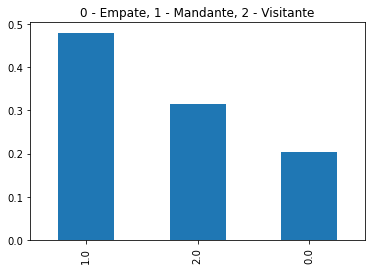

In [45]:
df2.resultado.value_counts(normalize=True).plot(kind='bar');
plt.title('0 - Empate, 1 - Mandante, 2 - Visitante');

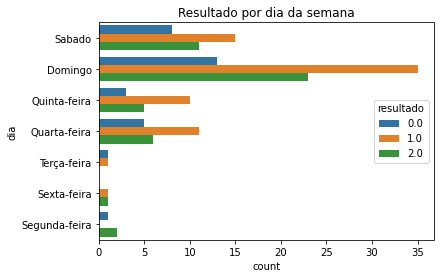

In [46]:
sns.countplot(y=df2.dia, hue=df2.resultado);
plt.title('Resultado por dia da semana');

# 3. Feature Engineering 

In [47]:
df3 = df2.copy()

In [48]:
to_drop = ['index', 'vencedor', 'ID']
df3 = df3.drop(to_drop, axis = 1)

In [49]:
df3.head()

,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_chutes_no_alvo,visitante_posse_de_bola,visitante_passes,visitante_precisao_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,resultado
0,2,2018-04-21,19:00,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,maracana,RJ,...,3.824324,47.364865,403.270270,78.094595,14.959459,1.945946,0.121622,1.675676,4.702703,1.0
1,4,2018-05-06,16:00,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,maracana,RJ,...,4.443709,51.344371,439.887417,80.596026,15.874172,2.529801,0.192053,1.569536,5.675497,1.0
2,6,2018-05-19,19:01,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,maracana,RJ,...,3.902655,46.441441,385.876106,79.603604,15.309735,2.424779,0.159292,1.185841,4.601770,0.0
3,8,2018-05-31,16:00,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,maracana,RJ,...,4.360000,47.133333,393.760000,78.793333,15.646667,2.080000,0.140000,1.253333,5.386667,1.0
4,9,2018-06-03,16:00,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,maracana,RJ,...,3.894040,52.853333,470.788079,82.300000,13.562914,1.894040,0.099338,1.079470,5.225166,1.0


In [50]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
arena                                object
mandante_estado                      object
visitante_estado                     object
visitante_chutes                    float64
visitante_chutes_no_alvo            float64
visitante_posse_de_bola             float64
visitante_passes                    float64
visitante_precisao_passes           float64
visitante_faltas                    float64
visitante_cartao_amarelo            float64
visitante_cartao_vermelho           float64
visitante_impedimentos              float64
visitante_escanteios                float64
resultado                           float64
dtype: object

In [51]:
df3.loc[:,'hora_decimal'] = pd.to_datetime(df3.hora).dt.hour + pd.to_datetime(df3.hora).dt.minute / 60

In [52]:
df3['hora_sin_'] = df3['hora_decimal'].apply(lambda x: np.sin(x * (2 * np.pi/24)))

In [53]:
df3 = df3.drop(['hora', 'hora_decimal'], axis = 1)

In [54]:
df3.insert(2, 'hora_sin', df3.hora_sin_)

In [55]:
df3 = df3.drop('hora_sin_', axis = 1)

In [56]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_chutes_no_alvo,visitante_posse_de_bola,visitante_passes,visitante_precisao_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,resultado
0,2,2018-04-21,-0.965926,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,maracana,RJ,...,3.824324,47.364865,403.270270,78.094595,14.959459,1.945946,0.121622,1.675676,4.702703,1.0
1,4,2018-05-06,-0.866025,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,maracana,RJ,...,4.443709,51.344371,439.887417,80.596026,15.874172,2.529801,0.192053,1.569536,5.675497,1.0
2,6,2018-05-19,-0.964787,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,maracana,RJ,...,3.902655,46.441441,385.876106,79.603604,15.309735,2.424779,0.159292,1.185841,4.601770,0.0
3,8,2018-05-31,-0.866025,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,maracana,RJ,...,4.360000,47.133333,393.760000,78.793333,15.646667,2.080000,0.140000,1.253333,5.386667,1.0
4,9,2018-06-03,-0.866025,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,maracana,RJ,...,3.894040,52.853333,470.788079,82.300000,13.562914,1.894040,0.099338,1.079470,5.225166,1.0


In [57]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora_sin                            float64
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
arena                                object
mandante_estado                      object
visitante_estado                     object
visitante_chutes                    float64
visitante_chutes_no_alvo            float64
visitante_posse_de_bola             float64
visitante_passes                    float64
visitante_precisao_passes           float64
visitante_faltas                    float64
visitante_cartao_amarelo            float64
visitante_cartao_vermelho           float64
visitante_impedimentos              float64
visitante_escanteios                float64
resultado                           float64
dtype: object

## 3.1 Features creation 

In [58]:
df3['ano'] = df3.data.dt.year
df3['dia_do_mes'] = df3.data.dt.day
df3['mes'] = df3.data.dt.month
df3['semana_do_ano'] = df3.data.dt.weekofyear

df3.head()

/tmp/ipykernel_39509/3886982136.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['semana_do_ano'] = df3.data.dt.weekofyear


,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,resultado,ano,dia_do_mes,mes,semana_do_ano
0,2,2018-04-21,-0.965926,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,maracana,RJ,...,14.959459,1.945946,0.121622,1.675676,4.702703,1.0,2018,21,4,16
1,4,2018-05-06,-0.866025,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,maracana,RJ,...,15.874172,2.529801,0.192053,1.569536,5.675497,1.0,2018,6,5,18
2,6,2018-05-19,-0.964787,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,maracana,RJ,...,15.309735,2.424779,0.159292,1.185841,4.601770,0.0,2018,19,5,20
3,8,2018-05-31,-0.866025,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,maracana,RJ,...,15.646667,2.080000,0.140000,1.253333,5.386667,1.0,2018,31,5,22
4,9,2018-06-03,-0.866025,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,maracana,RJ,...,13.562914,1.894040,0.099338,1.079470,5.225166,1.0,2018,3,6,22


## 3.1 Data transformation 

In [59]:
# month
df3['mes_sin'] = df3['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df3['mes_cos'] = df3['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df3['dia_do_mes_sin'] = df3['dia_do_mes'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df3['dia_do_mes_cos'] = df3['dia_do_mes'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df3['semana_do_ano_sin'] = df3['semana_do_ano'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df3['semana_do_ano_cos'] = df3['semana_do_ano'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [60]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,ano,dia_do_mes,mes,semana_do_ano,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos
0,2,2018-04-21,-0.965926,Sabado,Flamengo,America-MG,4-1-4-1,4-2-3-1,maracana,RJ,...,2018,21,4,16,8.660254e-01,-0.500000,-0.951057,-0.309017,0.935016,-0.354605
1,4,2018-05-06,-0.866025,Domingo,Flamengo,Internacional,4-1-4-1,4-1-4-1,maracana,RJ,...,2018,6,5,18,5.000000e-01,-0.866025,0.951057,0.309017,0.822984,-0.568065
2,6,2018-05-19,-0.964787,Sabado,Flamengo,Vasco,4-1-4-1,4-2-3-1,maracana,RJ,...,2018,19,5,20,5.000000e-01,-0.866025,-0.743145,-0.669131,0.663123,-0.748511
3,8,2018-05-31,-0.866025,Quinta-feira,Flamengo,Bahia,4-1-4-1,4-2-4-0,maracana,RJ,...,2018,31,5,22,5.000000e-01,-0.866025,0.207912,0.978148,0.464723,-0.885456
4,9,2018-06-03,-0.866025,Domingo,Flamengo,Corinthians,4-1-4-1,4-2-4-0,maracana,RJ,...,2018,3,6,22,1.224647e-16,-1.000000,0.587785,0.809017,0.464723,-0.885456


In [61]:
# rodadas
df3['rodadas_sin'] = df3['rodada'].apply(lambda x: np.sin(x * (2 * np.pi/38)))
df3['rodadas_cos'] = df3['rodada'].apply(lambda x: np.cos(x * (2 * np.pi/38)))

In [62]:
df3.columns.tolist()

['rodada',
 'data',
 'hora_sin',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'arena',
 'mandante_estado',
 'visitante_estado',
 'visitante_chutes',
 'visitante_chutes_no_alvo',
 'visitante_posse_de_bola',
 'visitante_passes',
 'visitante_precisao_passes',
 'visitante_faltas',
 'visitante_cartao_amarelo',
 'visitante_cartao_vermelho',
 'visitante_impedimentos',
 'visitante_escanteios',
 'resultado',
 'ano',
 'dia_do_mes',
 'mes',
 'semana_do_ano',
 'mes_sin',
 'mes_cos',
 'dia_do_mes_sin',
 'dia_do_mes_cos',
 'semana_do_ano_sin',
 'semana_do_ano_cos',
 'rodadas_sin',
 'rodadas_cos']

In [63]:
to_drop = ['dia', 'mes', 'ano', 'data', 'rodada', 'dia_do_mes', 'semana_do_ano']
df3 = df3.drop(to_drop, axis=1)

In [64]:
df3.head()

,hora_sin,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,visitante_estado,visitante_chutes,visitante_chutes_no_alvo,...,visitante_escanteios,resultado,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.965926,Flamengo,America-MG,4-1-4-1,4-2-3-1,maracana,RJ,MG,12.891892,3.824324,...,4.702703,1.0,8.660254e-01,-0.500000,-0.951057,-0.309017,0.935016,-0.354605,0.324699,0.945817
1,-0.866025,Flamengo,Internacional,4-1-4-1,4-1-4-1,maracana,RJ,RS,12.728477,4.443709,...,5.675497,1.0,5.000000e-01,-0.866025,0.951057,0.309017,0.822984,-0.568065,0.614213,0.789141
2,-0.964787,Flamengo,Vasco,4-1-4-1,4-2-3-1,maracana,RJ,RJ,11.938053,3.902655,...,4.601770,0.0,5.000000e-01,-0.866025,-0.743145,-0.669131,0.663123,-0.748511,0.837166,0.546948
3,-0.866025,Flamengo,Bahia,4-1-4-1,4-2-4-0,maracana,RJ,BA,13.173333,4.360000,...,5.386667,1.0,5.000000e-01,-0.866025,0.207912,0.978148,0.464723,-0.885456,0.969400,0.245485
4,-0.866025,Flamengo,Corinthians,4-1-4-1,4-2-4-0,maracana,RJ,SP,11.655629,3.894040,...,5.225166,1.0,1.224647e-16,-1.000000,0.587785,0.809017,0.464723,-0.885456,0.996584,0.082579


In [65]:
df3.insert(len(df3.columns.tolist()), 'resultado_final', df3.resultado)

In [66]:
df3 = df3.drop('resultado', axis = 1)

In [67]:
df3['resultado_final'] = df3.resultado_final.astype(int)

In [68]:
df3.dtypes

hora_sin                     float64
mandante                      object
visitante                     object
formacao_mandante             object
formacao_visitante            object
arena                         object
mandante_estado               object
visitante_estado              object
visitante_chutes             float64
visitante_chutes_no_alvo     float64
visitante_posse_de_bola      float64
visitante_passes             float64
visitante_precisao_passes    float64
visitante_faltas             float64
visitante_cartao_amarelo     float64
visitante_cartao_vermelho    float64
visitante_impedimentos       float64
visitante_escanteios         float64
mes_sin                      float64
mes_cos                      float64
dia_do_mes_sin               float64
dia_do_mes_cos               float64
semana_do_ano_sin            float64
semana_do_ano_cos            float64
rodadas_sin                  float64
rodadas_cos                  float64
resultado_final                int64
d

In [69]:
categorical = ['mandante', 'visitante']
target = ['resultado_final']

df3_cat = df3[categorical]
df3_target = df3[target]

In [70]:
df3_cat_dummies = pd.get_dummies(df3_cat)

In [71]:
df3_cat_dummies

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Avai,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_CSA,mandante_Ceara,...,visitante_Gremio,visitante_Internacional,visitante_Juventude,visitante_Palmeiras,visitante_Parana,visitante_Santos,visitante_Sao Paulo,visitante_Sport,visitante_Vasco,visitante_Vitoria
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
categorical.append(target[0])

In [73]:
to_drop = ['mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'arena',
           'mandante_estado',
           'visitante_estado',
           'resultado_final']

In [74]:
df3_numeric = df3.drop(to_drop, axis=1)

In [75]:
columns = df3_numeric.columns.tolist()

In [76]:
ss = StandardScaler()
df3_numeric_scaled = pd.DataFrame(ss.fit_transform(df3_numeric), columns=columns)

In [77]:
df3_numeric_scaled.head()

,hora_sin,visitante_chutes,visitante_chutes_no_alvo,visitante_posse_de_bola,visitante_passes,visitante_precisao_passes,visitante_faltas,visitante_cartao_amarelo,visitante_cartao_vermelho,visitante_impedimentos,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.608558,-0.628594,-1.149864,-1.251896,-1.043831,-1.699672,-0.363629,-1.739478,-0.064150,1.856592,-1.259964,2.192844,-0.793995,-1.486235,-0.392213,2.235222,-0.464693,0.459194,1.337588
1,-0.267492,-0.739187,-0.464192,-0.541584,-0.370520,-0.715651,1.121556,2.273358,2.559600,1.302030,0.027790,1.558899,-1.310281,1.253283,0.472745,2.048579,-0.775037,0.868628,1.116013
2,-0.604672,-1.274114,-1.063151,-1.416720,-1.363672,-1.106054,0.205100,1.551538,1.339170,-0.702728,-1.393576,1.558899,-1.310281,-1.186790,-0.896203,1.782255,-1.037384,1.183932,0.773502
3,-0.267492,-0.438125,-0.556860,-1.293223,-1.218704,-1.424800,0.752164,-0.818125,0.620492,-0.350088,-0.354554,1.558899,-1.310281,0.182969,1.409214,1.451727,-1.236485,1.370939,0.347169
4,-0.267492,-1.465248,-1.072688,-0.272246,0.197677,-0.045337,-2.631148,-2.096229,-0.894282,-1.258499,-0.568344,0.692913,-1.499255,0.730082,1.172511,1.451727,-1.236485,1.409383,0.116785


In [78]:
df3_final = pd.concat([df3_cat_dummies, df3_numeric_scaled, df3_target], axis =1)

In [79]:
df3_final

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Avai,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_CSA,mandante_Ceara,...,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,0,0,0,0,0,0,0,0,0,0,...,-1.259964,2.192844,-0.793995,-1.486235,-0.392213,2.235222,-0.464693,4.591944e-01,1.337588,1
1,0,0,0,0,0,0,0,0,0,0,...,0.027790,1.558899,-1.310281,1.253283,0.472745,2.048579,-0.775037,8.686279e-01,1.116013,1
2,0,0,0,0,0,0,0,0,0,0,...,-1.393576,1.558899,-1.310281,-1.186790,-0.896203,1.782255,-1.037384,1.183932e+00,0.773502,0
3,0,0,0,0,0,0,0,0,0,0,...,-0.354554,1.558899,-1.310281,0.182969,1.409214,1.451727,-1.236485,1.370939e+00,0.347169,1
4,0,0,0,0,0,0,0,0,0,0,...,-0.568344,0.692913,-1.499255,0.730082,1.172511,1.451727,-1.236485,1.409383e+00,0.116785,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0,0,0,0,0,0,0,0,0,0,...,0.810361,-0.173073,1.132812,1.315884,-0.106025,-0.569486,1.014959,-1.370939e+00,0.347169,0
148,0,0,0,0,0,0,0,0,0,0,...,0.810361,-0.173073,1.132812,0.182969,-1.328682,-0.569486,1.014959,-1.183932e+00,0.773502,2
149,0,0,0,0,0,0,0,0,0,0,...,0.810361,-0.173073,1.132812,0.953839,-0.896203,-0.569486,1.014959,-8.686279e-01,1.116013,2
150,0,0,0,0,0,0,0,0,0,0,...,0.810361,0.692913,1.321786,0.730082,-1.091978,0.086750,1.410260,-6.730913e-01,1.243764,0


# 4.0 Feature selection and scaling 

In [80]:
df4 = df3_final.copy()

In [81]:
df4 = df4.dropna()

In [82]:
df4.head()

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Avai,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_CSA,mandante_Ceara,...,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,0,0,0,0,0,0,0,0,0,0,...,-1.259964,2.192844,-0.793995,-1.486235,-0.392213,2.235222,-0.464693,0.459194,1.337588,1
1,0,0,0,0,0,0,0,0,0,0,...,0.027790,1.558899,-1.310281,1.253283,0.472745,2.048579,-0.775037,0.868628,1.116013,1
2,0,0,0,0,0,0,0,0,0,0,...,-1.393576,1.558899,-1.310281,-1.186790,-0.896203,1.782255,-1.037384,1.183932,0.773502,0
3,0,0,0,0,0,0,0,0,0,0,...,-0.354554,1.558899,-1.310281,0.182969,1.409214,1.451727,-1.236485,1.370939,0.347169,1
4,0,0,0,0,0,0,0,0,0,0,...,-0.568344,0.692913,-1.499255,0.730082,1.172511,1.451727,-1.236485,1.409383,0.116785,1


In [83]:
X = df4.drop(['resultado_final'], axis=1)
y = df4.resultado_final

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)

In [85]:
undersampling = RandomOverSampler(random_state=32)

In [86]:
X_train, y_train = undersampling.fit_resample(X_train, y_train)

/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='resultado_final', ylabel='count'>

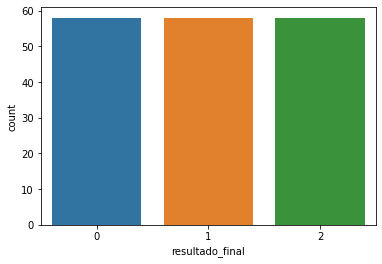

In [87]:
sns.countplot(y_train)

# 5.0 Machine Learning Models 

## 5.1 Logistic Regression 

In [88]:
clf_lg = LogisticRegression().fit(X_train, y_train)
y_hat_lg = clf_lg.predict(X_test)

In [89]:
accuracy_score(y_test, y_hat_lg)

0.42105263157894735

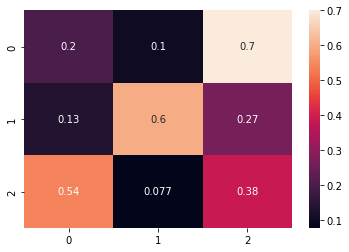

In [90]:
sns.heatmap(confusion_matrix(y_test, y_hat_lg, normalize='true'), annot=True);

In [91]:
print(classification_report(y_test, y_hat_lg))

              precision    recall  f1-score   support

           0       0.18      0.20      0.19        10
           1       0.82      0.60      0.69        15
           2       0.31      0.38      0.34        13

    accuracy                           0.42        38
   macro avg       0.44      0.39      0.41        38
weighted avg       0.48      0.42      0.44        38



## 5.2 XGBoost 

In [92]:
clf_xgb = xgb.XGBRFClassifier(n_estimators = 1000).fit(X_train, y_train)
yhat_xgb = clf_xgb.predict(X_test)

/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:01:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [93]:
accuracy_score(y_test, yhat_xgb)

0.47368421052631576

<AxesSubplot:>

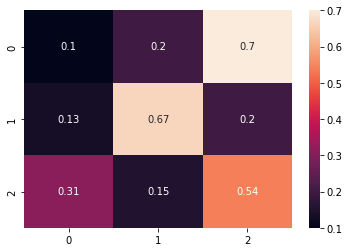

In [94]:
sns.heatmap(confusion_matrix(y_test, yhat_xgb, normalize='true'), annot=True, )

In [95]:
print(classification_report(y_test, yhat_xgb))

              precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.71      0.67      0.69        15
           2       0.41      0.54      0.47        13

    accuracy                           0.47        38
   macro avg       0.42      0.44      0.42        38
weighted avg       0.46      0.47      0.46        38



## 5.3 Random Forests

In [96]:
clf_rf = RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42).fit(X_train, y_train)
yhat_rf = clf_rf.predict(X_test)

In [97]:
accuracy_score(y_test, yhat_rf)

0.5

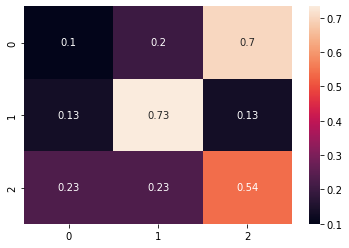

In [98]:
sns.heatmap(confusion_matrix(y_test, yhat_rf, normalize='true'), annot=True, );

In [99]:
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.69      0.73      0.71        15
           2       0.44      0.54      0.48        13

    accuracy                           0.50        38
   macro avg       0.43      0.46      0.44        38
weighted avg       0.46      0.50      0.48        38



## 5.4 SVM 

In [100]:
clf_svc = svm.SVC().fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)

In [101]:
accuracy_score(y_test, y_hat_svc)

0.5263157894736842

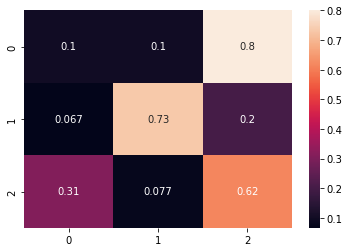

In [102]:
sns.heatmap(confusion_matrix(y_test, y_hat_svc, normalize='true'), annot=True);

In [103]:
print(classification_report(y_test, y_hat_svc))

              precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.85      0.73      0.79        15
           2       0.42      0.62      0.50        13

    accuracy                           0.53        38
   macro avg       0.48      0.48      0.47        38
weighted avg       0.52      0.53      0.51        38



## 5.5 Naive Bayes 

In [104]:
clf_gb = GaussianNB().fit(X_train, y_train)
y_hat_gnb = clf_gb.predict(X_test)

In [105]:
accuracy_score(y_test, y_hat_gnb)

0.3157894736842105

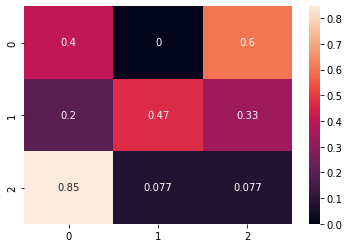

In [106]:
sns.heatmap(confusion_matrix(y_test, y_hat_gnb, normalize='true'), annot=True, );

In [107]:
print(classification_report(y_test, y_hat_gnb))

              precision    recall  f1-score   support

           0       0.22      0.40      0.29        10
           1       0.88      0.47      0.61        15
           2       0.08      0.08      0.08        13

    accuracy                           0.32        38
   macro avg       0.39      0.31      0.32        38
weighted avg       0.43      0.32      0.34        38



## 5.6 SGD Classifier 

In [108]:
clf_sgd = SGDClassifier().fit(X_train, y_train)
y_hat_sgd = clf_sgd.predict(X_test)

In [109]:
accuracy_score(y_test, y_hat_sgd)

0.3684210526315789

<AxesSubplot:>

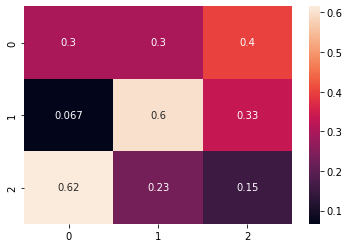

In [110]:
sns.heatmap(confusion_matrix(y_test, y_hat_sgd, normalize='true'), annot=True, )

In [111]:
print(classification_report(y_test, y_hat_sgd))

              precision    recall  f1-score   support

           0       0.25      0.30      0.27        10
           1       0.60      0.60      0.60        15
           2       0.18      0.15      0.17        13

    accuracy                           0.37        38
   macro avg       0.34      0.35      0.35        38
weighted avg       0.36      0.37      0.37        38



## 5.7 Decision Tree

In [112]:
clf_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_hat_dt = clf_dt.predict(X_test)

In [113]:
accuracy_score(y_test, y_hat_dt)

0.5

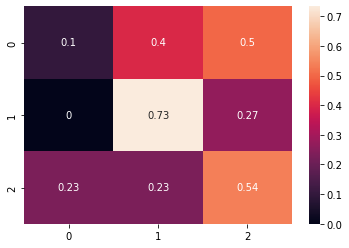

In [114]:
sns.heatmap(confusion_matrix(y_test, y_hat_dt, normalize='true'), annot=True, );

In [115]:
print(classification_report(y_test, y_hat_dt))

              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.61      0.73      0.67        15
           2       0.44      0.54      0.48        13

    accuracy                           0.50        38
   macro avg       0.43      0.46      0.43        38
weighted avg       0.46      0.50      0.47        38



## 5.8 MLP

In [116]:
clf_mlp = MLPClassifier(max_iter=500).fit(X_train, y_train)
y_hat_mlp = clf_mlp.predict(X_test)

In [117]:
accuracy_score(y_test, y_hat_mlp)

0.3684210526315789

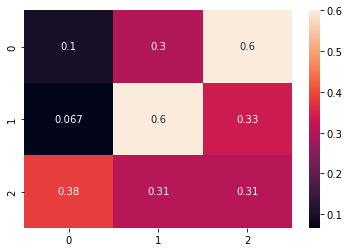

In [118]:
sns.heatmap(confusion_matrix(y_test, y_hat_mlp, normalize='true'), annot=True, );

In [119]:
print(classification_report(y_test, y_hat_mlp))

              precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.56      0.60      0.58        15
           2       0.27      0.31      0.29        13

    accuracy                           0.37        38
   macro avg       0.32      0.34      0.33        38
weighted avg       0.35      0.37      0.36        38



# 6.0 Ensemble 

In [120]:
import warnings
warnings.filterwarnings("ignore")

In [121]:
eclf = VotingClassifier(estimators=[('logistic', clf_lg), ('xgb', clf_xgb), ('random_forest', clf_rf), ('naive_bayes', clf_gb), ('decision_tree', clf_dt), ('mlp', clf_mlp)], voting='hard')

In [122]:
for clf, label in zip([clf_lg, clf_xgb, clf_rf, clf_gb, clf_dt], ['logistic', 'xgb', 'random_forest', 'naive_bayes', 'decision_tree', 'mlp' ]):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.47 (+/- 0.16) [logistic]
[12:01:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_m

In [129]:
eclf = VotingClassifier(estimators=[('xgb', clf_xgb), ('svc', clf_svc), ('dt', clf_dt), ('rf', clf_rf)], voting='hard').fit(X_train, y_train)

[12:04:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [130]:
y_hat_eclf = eclf.predict(X_test)

In [131]:
accuracy_score(y_test, y_hat_eclf)

0.5263157894736842

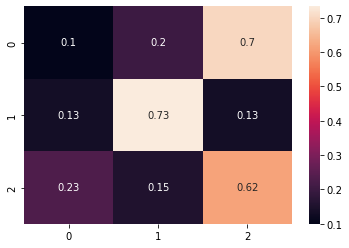

In [132]:
sns.heatmap(confusion_matrix(y_test, y_hat_eclf, normalize='true'), annot=True, );

In [127]:
print(classification_report(y_test, y_hat_eclf))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24        10
           1       0.75      0.80      0.77        15
           2       0.40      0.46      0.43        13

    accuracy                           0.53        38
   macro avg       0.48      0.49      0.48        38
weighted avg       0.51      0.53      0.51        38

